<a href="https://colab.research.google.com/github/tnfru/colab_research/blob/master/MNIST_99percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys, math
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
AUTO = tf.data.experimental.AUTOTUNE
from google.colab import drive

TensorFlow 2.x selected.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
try: 
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus)
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 


In [0]:
def display_training_curves(training, validation, title, subplot):
  #stolen from google colab
  if subplot%10==1:
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [0]:
drive.mount('/content/drive')

In [53]:
PATH="/content/drive/My Drive/data/"

train_df = shuffle(pd.read_csv(PATH + "train.csv"))
test_df = pd.read_csv(PATH + "test.csv") / 255
test = test_df.values.reshape(-1, 28, 28, 1)
sample_submission = pd.read_csv(PATH + "sample_submission.csv")
train_df.shape

(42000, 785)

In [54]:
train_df.isnull().any().sum(), test_df.isnull().any().sum()

(0, 0)

In [0]:
VALIDATION_SPLIT = 0.1
SPLIT = int(len(train_df) * VALIDATION_SPLIT)
IMG_SIZE = [28, 28]

val_df = train_df[:SPLIT]
train_df = train_df[SPLIT:]

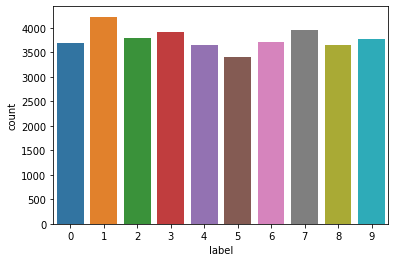

In [28]:
sns.countplot(train_df['label']);

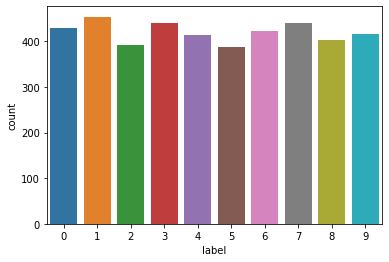

In [29]:
sns.countplot(val_df['label']);

In [0]:
train_target = train_df.pop('label').values
train_target = to_categorical(train_target, num_classes=10)
val_target = val_df.pop('label').values
val_target = to_categorical(val_target, num_classes=10)

train_values = train_df.values.reshape(-1, 28, 28, 1) / 255
val_values = val_df.values.reshape(-1, 28, 28, 1) / 255

train = tf.data.Dataset.from_tensor_slices((train_values, train_target))
val = tf.data.Dataset.from_tensor_slices((val_values, val_target))

In [0]:
def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1337)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO)
  return dataset

In [0]:
l = tf.keras.layers

In [0]:
def create_model():
  model = tf.keras.Sequential([
      l.Conv2D(kernel_size=3, filters=20, padding='same', activation='relu', input_shape=(*IMG_SIZE, 1)),
      l.BatchNormalization(),
      l.Conv2D(kernel_size=3, filters=50, padding='same', activation='relu'),
      l.BatchNormalization(),
      l.MaxPooling2D(),
      l.Dropout(0.5),

      l.Conv2D(kernel_size=3, filters=80, padding='same', activation='relu'),
      l.BatchNormalization(),
      l.Conv2D(kernel_size=3, filters=100, padding='same', activation='relu'),
      l.BatchNormalization(),
      l.MaxPooling2D(),
      l.Dropout(0.5),

      l.Conv2D(kernel_size=3, filters=100, padding='same', activation='relu'),
      l.BatchNormalization(),
      l.Conv2D(kernel_size=3, filters=120, padding='same', activation='relu'),
      l.BatchNormalization(),
      l.MaxPooling2D(),
      l.Dropout(0.5),

      l.Conv2D(kernel_size=3, filters=80, padding='same', activation='relu'),
      l.BatchNormalization(),
      l.Conv2D(kernel_size=1, filters=40, padding='same', activation='relu'),
      l.BatchNormalization(),

      l.GlobalAveragePooling2D(),
      l.Dense(10, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  return model

In [82]:
with strategy.scope():
  model = create_model()

  model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 28, 28, 20)        200       
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 20)        80        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 28, 28, 50)        9050      
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 50)        200       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 50)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 14, 14, 80)       

In [83]:
train_set = get_batched_dataset(train, train=True)
val_set = get_batched_dataset(val)

train_df.shape, val_df.shape

((42000, 785), (4200, 784))

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1)


In [85]:
EPOCHS = 20
BATCH_SIZE = 32
steps_per_epoch = train_values.shape[0] // BATCH_SIZE

history = model.fit(datagen.flow(train_values, train_target, batch_size=32), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=val_set)

  ...
    to  
  ['...']
Train for 1181 steps, validate for 132 steps
Epoch 1/20
1181/1181 [==============================] - 23s 19ms/step - loss: 0.3302 - accuracy: 0.8983 - val_loss: 0.0506 - val_accuracy: 0.9855
Epoch 2/20
1181/1181 [==============================] - 18s 15ms/step - loss: 0.1032 - accuracy: 0.9690 - val_loss: 0.0357 - val_accuracy: 0.9905
Epoch 3/20
1181/1181 [==============================] - 18s 15ms/step - loss: 0.0823 - accuracy: 0.9750 - val_loss: 0.0352 - val_accuracy: 0.9898
Epoch 4/20
1181/1181 [==============================] - 18s 16ms/step - loss: 0.0715 - accuracy: 0.9791 - val_loss: 0.0270 - val_accuracy: 0.9912
Epoch 5/20
1181/1181 [==============================] - 18s 15ms/step - loss: 0.0621 - accuracy: 0.9812 - val_loss: 0.0336 - val_accuracy: 0.9898
Epoch 6/20
1181/1181 [==============================] - 18s 15ms/step - loss: 0.0558 - accuracy: 0.9838 - val_loss: 0.0204 - val_accuracy: 0.9929
Epoch 7/20
1181/1181 [==============================] 

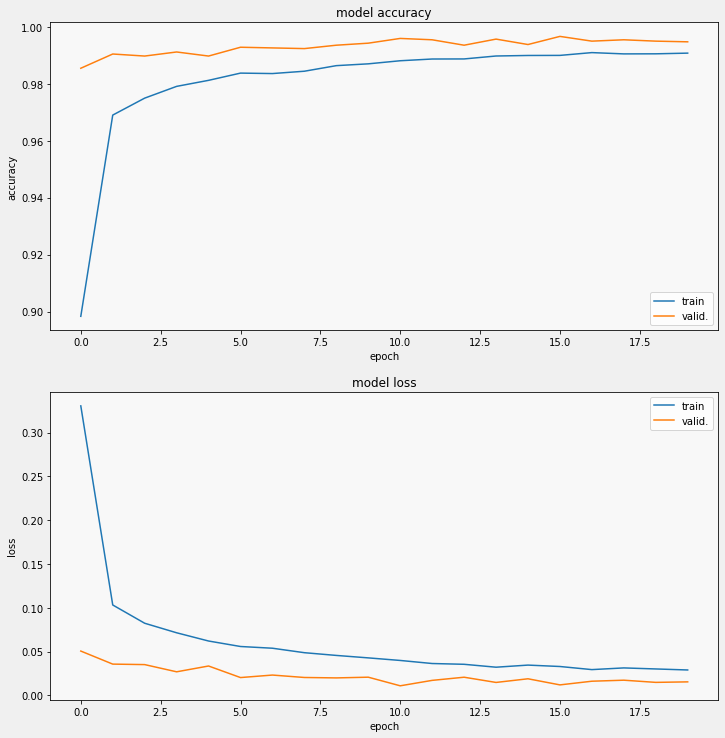

In [86]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)